In [4]:
# Francisco Dominguez Mateos
# 26/06/2020
# Generative Modeling by Estimating Gradients of Data Distribution in JAX
# from: https://github.com/google/jax/blob/master/docs/notebooks/score_matching.ipynb
#!conda install -c anaconda scikit-learn --yes

In [21]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import numpy as onp
import numpy as old_np

from sklearn.datasets import load_digits
from sklearn.datasets import make_swiss_roll

import jax
import jax.numpy as np
from jax.experimental import optimizers
from jax.experimental import stax
from functools import partial

# Score Matching
The idea behind score matching is to learn scores: the gradients of $\log p(x)$ w.r.t. $x$. When trained this model can "improve" a sample $x$ by changing it in the direction of highest log-probability. However, training such model can get tricky. When predicting a continuous variable, ML folks usually minimize squared error:
$$ L_{mse} = E_{x \sim p(x)} \left\lVert model(x) - \nabla_x \log p(x) \right\lVert_2^2 $$
One can't minimize this explicitly because the real $\nabla_x log p(x)$ is usually unknown. 
But, it has been proof that the arg-minimum of $L_{mse}$ can be found by minimizing a more tractable objective:
$$ L_{matching} = E_{x \sim p(x)} \space tr( \space \mathbf{J}_x [\space model(x) \space]) + \frac12 \left\Vert model(x) \right\lVert_2^2 $$
Here $tr( \space \mathbf{J}_x [\space model(x) \space])$ is a trace of Jacobian of $model(x)$ w.r.t. $x$. Now all it takes is to minimize the second objective.

Insight: model(x) is just one aproximation to $\nabla_x \log p(x)$. We can think that model(x) is the gradient vector at x.

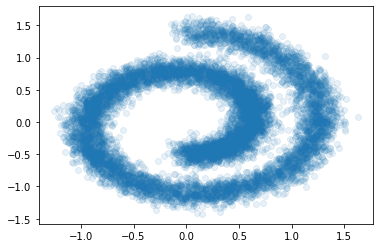

In [5]:
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return onp.array(x)

plt.scatter(*sample_batch(10**4).T, alpha=0.1)

In [7]:
# Set up network to predict scores
net_init, net_apply = stax.serial(
    stax.Dense(128), stax.Softplus,
    stax.Dense(128), stax.Softplus,
    stax.Dense(2),
)

# Create optimizer. Note that both network and optimizer returns pure (stateless) functions
opt_init, opt_update, get_params = optimizers.adam(1e-3)

In [8]:
# v-- jax.jit compiles a function for efficient CPU and GPU execution

@jax.jit
def compute_loss(net_params, inputs):
    # v-- a function that computes jacobian by forward mode differentiation
    jacobian = jax.jacfwd(net_apply, argnums=-1)
    
    # we use jax.vmap to vectorize jacobian function along batch dimension
    batch_jacobian = jax.vmap(partial(jacobian, net_params))(inputs)  # [batch, dim, dim]
    
    trace_jacobian = np.trace(batch_jacobian, axis1=1, axis2=2)
    output_norm_sq = np.square(net_apply(net_params, inputs)).sum(axis=1)
    
    return np.mean(trace_jacobian + 1/2 * output_norm_sq)


@jax.jit
def train_step(step_i, opt_state, batch):
    net_params = get_params(opt_state)
    loss = compute_loss(net_params, batch)
    grads = jax.grad(compute_loss, argnums=0)(net_params, batch)
    return loss, opt_update(step_i, grads, opt_state)

In [10]:
out_shape, net_params = net_init(jax.random.PRNGKey(seed=42), input_shape=(-1, 2))
opt_state = opt_init(net_params)

loss_history = []

/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


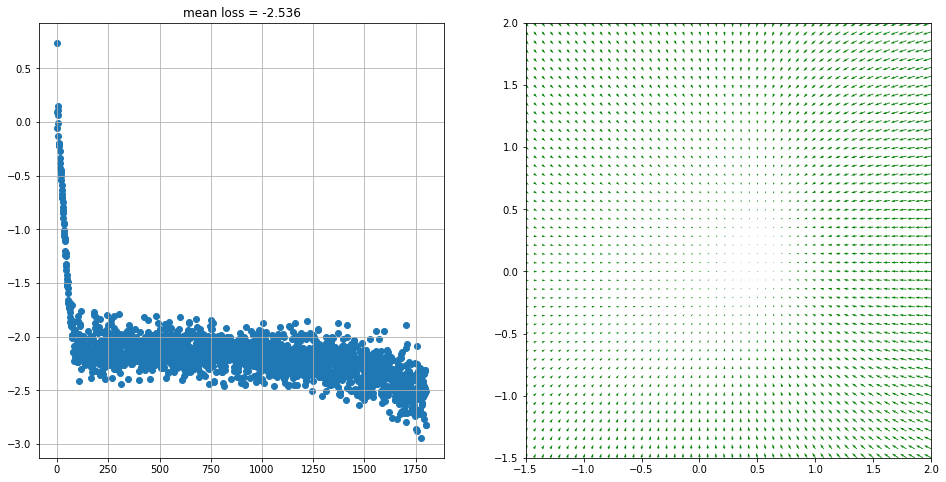

In [11]:
for i in range(2000):
    x = sample_batch(size=128)
    loss, opt_state = train_step(i, opt_state, x)
    loss_history.append(loss.item())
    
    if i % 200 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("mean loss = %.3f" % np.mean(np.array(loss_history[-32:])))
        plt.scatter(np.arange(len(loss_history)), loss_history)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        net_params = get_params(opt_state)
        xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
        scores = net_apply(net_params, xx)
        scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
        scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

        plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
        plt.xlim(-1.5, 2.0)
        plt.ylim(-1.5, 2.0)
        plt.show()

In the next figure we can see that the aproximation of the gradient is not to bad but far from perfect. We have to keep in mind that this is a toy example, in real problems x is a very high dimensions where p(x) is unknown.

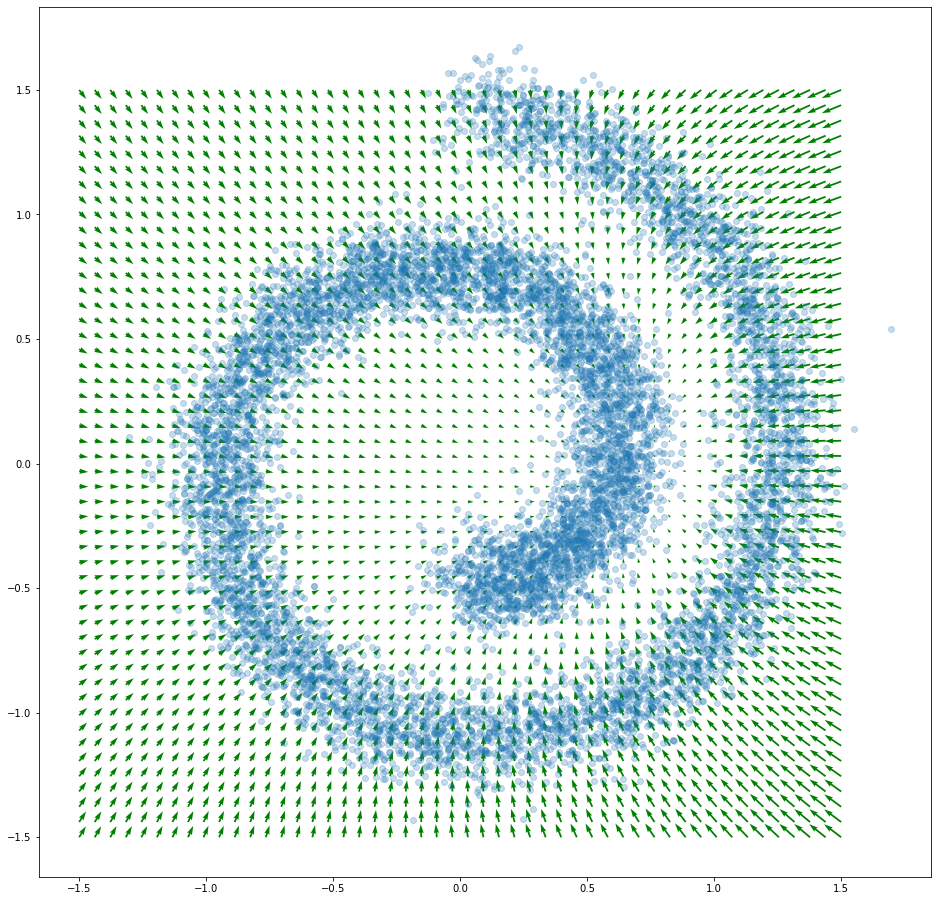

In [12]:
plt.figure(figsize=[16, 16])

net_params = get_params(opt_state)
xx = np.stack(np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.scatter(*sample_batch(10_000).T, alpha=0.25)

# Sampling with Langevin Dynamics

Once we have $\nabla_x log p(x)$, we can use it to generate data. One simple thing you can do is a gradient ascent w.r.t image to find a local maximum of p(x):

$$\hat x_{t + 1} := x_t + \epsilon \nabla_{x_t} log p(x_t)$$

In order to sample $x \sim p(x)$, one can run a slightly more sophisticated procedure:

$$\hat x_{t+1} := \hat x_t + \frac \epsilon 2 \nabla_{\hat x_t} log p(\hat x_t) + \sqrt \epsilon z_t, \quad z_t \sim N(0, I)$$

Performing this update multiple times in an MCMC fashion is a special case of Langevin Dynamics. Under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\hat x_t$ converges to a sample from $p(x)$

In [13]:
def sample_langevin(x_initial, *, net_params, key, eps=1e-2, eps_decay=0.9, num_steps=15, temperature=1.0):
    """ sample x ~ p(x) by applying approximate Langvenin Dynamics, return a sequence of x_t """
    x_t, x_sequence = x_initial, [x_initial]
    
    for t in range(num_steps):
        key, subkey = jax.random.split(key)
        z_t = jax.random.normal(subkey, shape=x_t.shape)
        x_t = x_t + eps / 2 * net_apply(net_params, x_t) + np.sqrt(eps) * temperature * z_t
        x_sequence.append(x_t)
        eps *= eps_decay
        
    return np.stack(x_sequence)

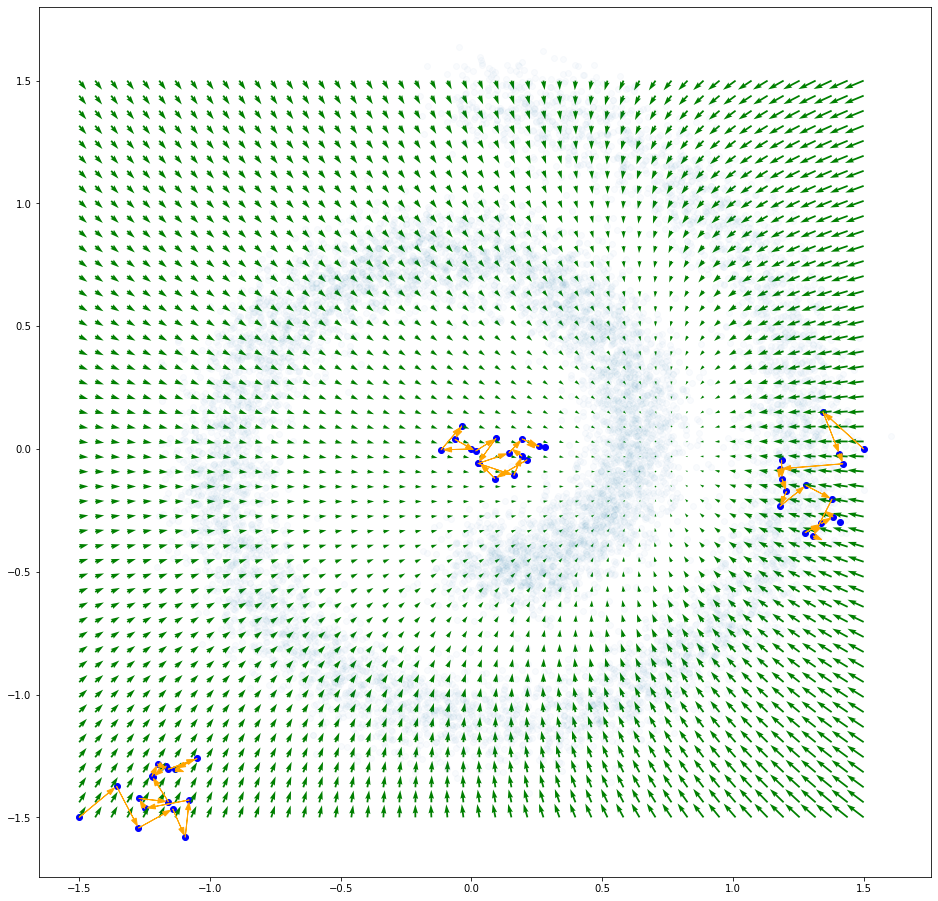

In [14]:
plt.figure(figsize=[16, 16])

key = jax.random.PRNGKey(42)
net_params = get_params(opt_state)

for x_initial in np.array([[-1.5, -1.5], [0, 0], [1.5, 0]]):
    key, subkey = jax.random.split(key)
    # sample x sequence
    xx = sample_langevin(x_initial, key=subkey, net_params=net_params)
    plt.scatter(xx.T[0], xx.T[1], color="blue")

    # draw arrows for each mcmc step
    deltas = (xx[1:] - xx[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(xx[i][0], xx[i][1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="orange")
    
# plot data points and gradients
plt.plot()
xx = np.stack(np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.scatter(*sample_batch(10_000).T, alpha=0.025)

# Sliced Score Matching

Now the problem with our previous loss function is that the computation of $tr(\mathbf{J}_x [\space model(x)])$ takes a $O(N^2 + N)$ time to compute, thus not being suitable for high-dimensional problems.

The solution is using jacobian vector products which can be easily computed using forward mode auto-differentiation. This method is called Sliced Score Matching.
Our new objective looks like this:
$$E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{x \sim p(x)} [ \mathbf{v}^T \mathbf{J}_x[model(x)] \mathbf{v} + \frac{1}{2} (\mathbf{v}^T model(x))^2 ]$$

Jacobian Vector products, by the way, can be easily computed using jax.jvp.

In [15]:
@jax.jit
def compute_ssm_loss(net_params, inputs, key):
    apply = jax.jit(partial(net_apply, net_params))
    batch_dot = partial(np.einsum, 'bu,bu->b')
    
    # generate random vectors from N(0, I)
    v = jax.random.normal(key, shape=inputs.shape)

    # predict score and comput jacobian of score times v
    score, jac_v = jax.jvp(apply, [inputs], [v])
    
    return np.mean(batch_dot(v, jac_v) + 1/2 * batch_dot(v, score) ** 2)

@jax.jit
def train_step(step_i, opt_state, batch, key):
    # the new compute_loss is random key dependent, thus we need a new train_step function
    net_params = get_params(opt_state)
    loss = compute_ssm_loss(net_params, batch, key)
    grads = jax.grad(compute_ssm_loss, argnums=0)(net_params, batch, key)
    return loss, opt_update(step_i, grads, opt_state)

In [19]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
out_shape, net_params = net_init(subkey, input_shape=(-1, 2))
opt_state = opt_init(net_params)

loss_history = []

This new aproach is even less accuracy but it still makes a rough good work. As we can see there is more variation on the loss. But the gradient field at a glanze is very similar.

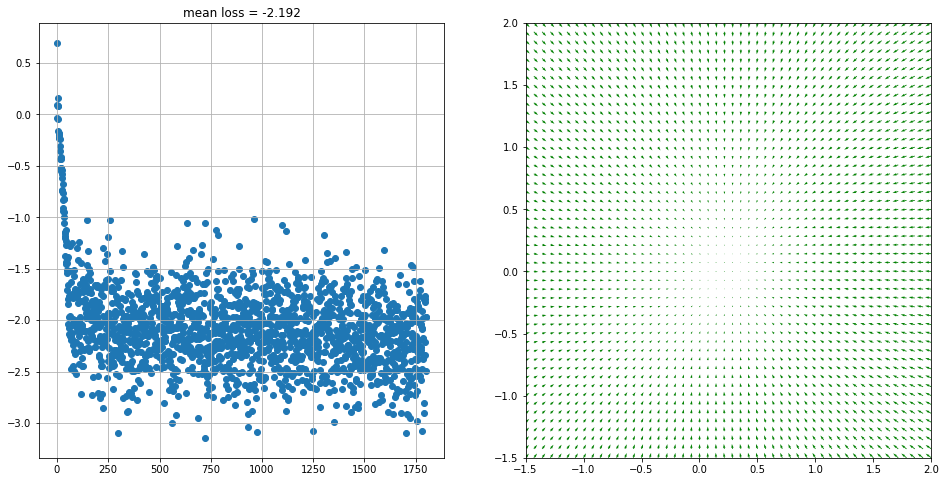

In [20]:
for i in range(2_000):
    x = sample_batch(size=128)
    
    key, subkey = jax.random.split(key)
    loss, opt_state = train_step(i, opt_state, x, subkey)
    loss_history.append(loss.item())
    
    if i % 200 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("mean loss = %.3f" % np.mean(np.array(loss_history[-32:])))
        plt.scatter(np.arange(len(loss_history)), loss_history)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        net_params = get_params(opt_state)
        xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
        scores = net_apply(net_params, xx)
        scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
        scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

        plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
        plt.xlim(-1.5, 2.0)
        plt.ylim(-1.5, 2.0)
        plt.show()

# Real case
With JAX all new need to do is just change the model and use data images of number and it will learn to generate "numbers?". Let see. 

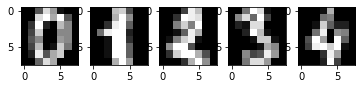

In [22]:
X, _ = load_digits(return_X_y=True)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i].reshape(8, 8), cmap='gray')
    

def sample_batch(size, noise=0.1):
    ix = old_np.random.randint(0, len(X), size=size)
    return np.array(X[ix] / 16 + noise * old_np.random.randn(size, 64))

In [23]:
# Set up network to predict scores
net_init, net_apply = stax.serial(
    stax.Dense(128), stax.Softplus,
    stax.Dense(128), stax.Softplus,
    stax.Dense(64),
)

# Create optimizer. Note that both network and optimizer returns pure (stateless) functions
opt_init, opt_update, get_params = optimizers.adam(1e-3)

key = jax.random.PRNGKey(seed=42)
key, subkey = jax.random.split(key)
out_shape, net_params = net_init(subkey, input_shape=(-1, 64))
opt_state = opt_init(net_params)

loss_history = []

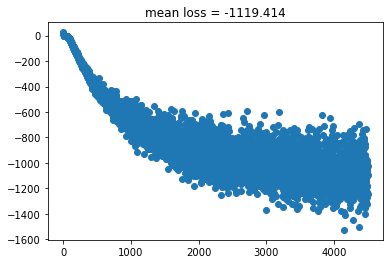

In [24]:
for i in range(5_000):
    x = sample_batch(size=128)
    key, subkey = jax.random.split(key)
    loss, opt_state = train_step(i, opt_state, x, subkey)
    loss_history.append(loss.item())
    
    if i % 500 == 0:
        clear_output(True)
        plt.title("mean loss = %.3f" % np.mean(np.array(loss_history[-32:])))
        plt.scatter(np.arange(len(loss_history)), loss_history)
        plt.show()

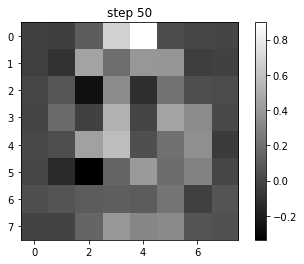

In [26]:
key, subkey = jax.random.split(key)
x = 0.1 * jax.random.uniform(subkey, shape=(64,))

xx = sample_langevin(x, net_params=get_params(opt_state), key=key,
                     eps=0.05, eps_decay=0.98, num_steps=50,
                     temperature=0.02)  # set low temperature to compensate for noise in training data

for t, x_t in enumerate(xx):
    clear_output(True)
    plt.imshow(x_t.reshape(8, 8), cmap='gray')
    plt.title('step %i' % t); plt.colorbar(); plt.show()